In [4]:
%load_ext autoreload
%autoreload 2

import analysis
import lmpsetup
import hmdsetup

import numpy as np
import matplotlib.pyplot as plt
import analysis

import mdtraj as md
import statsmodels.tsa.stattools
import MDAnalysis.analysis as mda

## Summary

**[1. Box improvements](#1)**: Slab is too thin and "normal" boxes too big. Let's try to get the dimensions from the "ideal" polymer Rg

**[2. Phase diagrams](#2)** : $\lambda=0.7$ was too much. Let's make an attempt using 0.8 

**[3. Phospho Phase diagrams](#3)** : Ramon wants to see phosphorilations also affect LLPS propensity. Since this system is the most similar. Let's do only 7D.

**[4. Single chain to criticality](#4)** : Let's also do all single chains to compare !

**[4.1 Maximization of Rg Difference](#4.1)**

**[5. Contact Test](#5)** : See if we can reproduce LAF1-RGG data

**[6. gHPS-T Test](#6)** : See if gHPS-T is good enough

**[7. Further Phase diagrams](#6)** : Just for testing. I want to do 0.75 at a much smaller range of temperatures

### 1. Box improvements <a id='1'></a>

Consider box scales as a multiple of Flory's ideal Rg:

In [6]:
s = analysis.Analysis(oliba_wd='/home/adria/data/prod/lammps/HPS-T/CspTm')
theo_rg = s.rw_rg()
exp_rg = s.rg()
print("Rg Theoretical : ", theo_rg)
print("Rg Experimental : ", exp_rg.mean(axis=1))

> Run Completed at 66.91% for CspTm. Ran 1338270000 steps for a total of 267655 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
Rg Theoretical :  18.2414363469547
Rg Experimental :  [19.61446464 17.12046742 15.65252325 15.39613385 16.51296799 19.20088394
 23.99203024]


Let's test it :

In [2]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/BOX-TEST',
                  host='@perdiu41',
                  protein='CPEB4',
                  chains=20, 
                  model='HPS-T',
                  save=1000,
                  t=int(1e9),
                  processors=4,
                  hps_scale=1.0,
                  use_random=True,
                  slab=True,
                  temperatures=[300],
                  debye=0.1).write_hps_files(silent=True)

### 2. Phase diagrams <a id='2'></a>

In [3]:
temperatures = np.linspace(250,350,5)

In [4]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/WT',
                  host='@perdiu43',
                  protein='CPEB4',
                  chains=20, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=4,
                  hps_scale=0.8,
                  use_random=True,
                  slab=True,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/WT for CPEB4     ║
║----------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                 ║
║       - Model = HPS-T                                                                        ║
║       - Chains = 20                                                                          ║
║       - Ionic Strength (mM) = 0.1                                                            ║
║       - Medium Permittivity = 80.0                                                           ║
║       - Temperatures (K) = [250. 275. 300. 325. 350.]                                        ║
║       - HPS Scale = 0.8                                                                      ║
╚═════════════════════════════

The result :

| 250| 275 | 300 | 325 | 350 |
| :---: | :---: | :---: | :---: | :---: |
|  <img src='img/9Juny/WT-T0-08.gif' width=200> | <img src='img/9Juny/WT-T1-08.gif' width=200> | <img src='img/9Juny/WT-T2-08.gif' width=200> | <img src='img/9Juny/WT-T3-08.gif' width=200> | <img src='img/9Juny/WT-T4-08.gif' width=200> |

Attempt for a phase diagram :

In [ ]:
pdWT = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/WT')
pds = pdWT.phase_diagram()
plt.plot(pds[0].mean(axis=1), pdWT.temperatures, 'bo')
plt.plot(pds[1].mean(axis=1), pdWT.temperatures, 'bo')

> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 


The system is pretty unstable at low T - we have big gaps for some frames. Let's check if the interface position predicted by the code is reasonable : 

> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


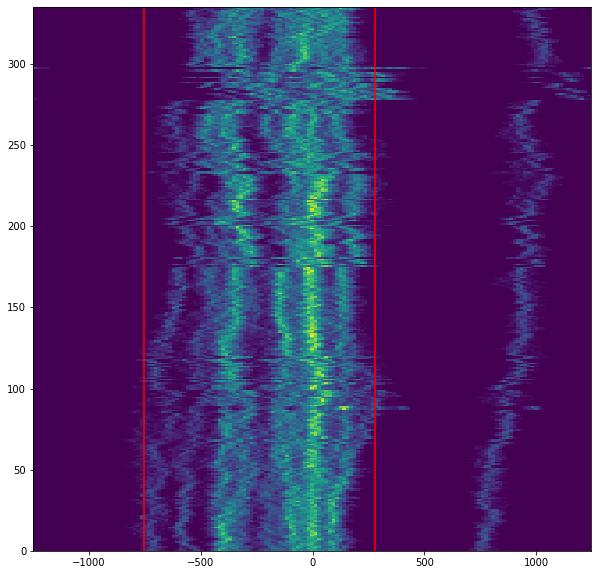

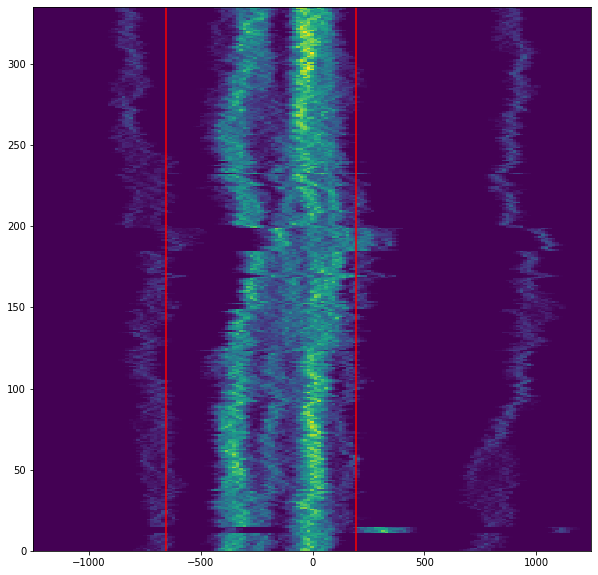

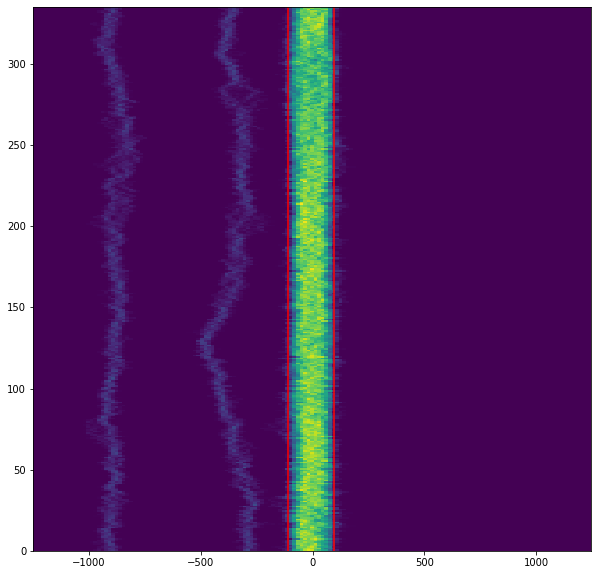

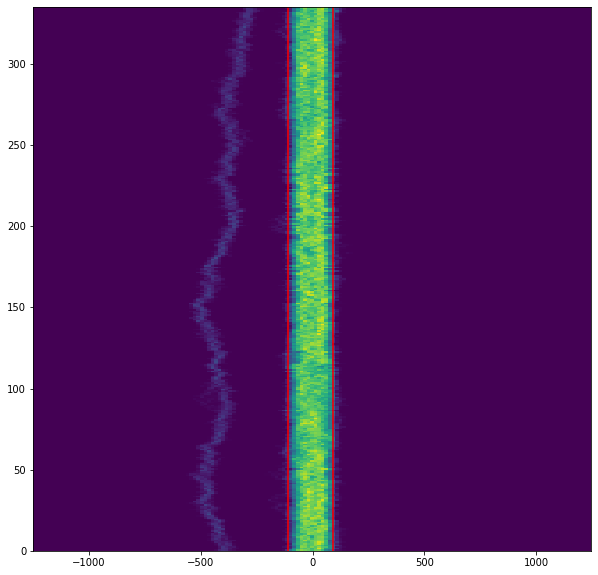

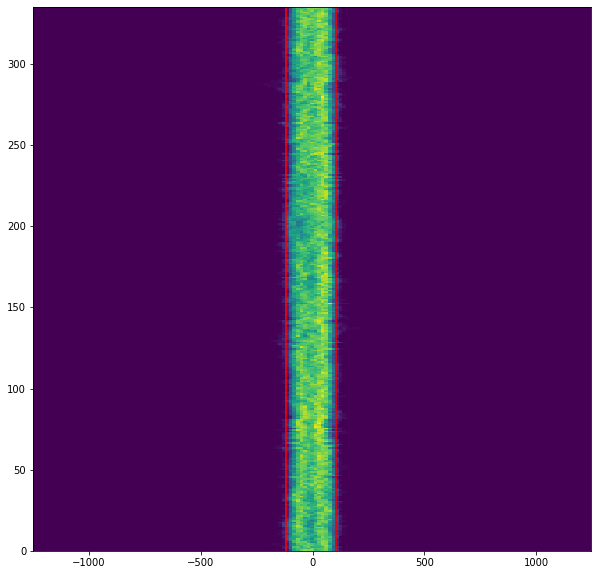

In [7]:
pdWT = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/WT')
for T in range(len(pdWT.temperatures)):
    z, rho_z = pdWT.density_profile(T=T, noise=False)
    interface = pdWT.interface_position(rho_z=rho_z.mean(axis=0), z=z)
    plt.figure(figsize=(10,10))
    plt.imshow(rho_z, extent=[z.min(), z.max(), 0,rho_z.shape[0]], aspect='auto')
    plt.axvline(interface[0], color='red')
    plt.axvline(interface[1], color='red')

In [5]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/D4',
                  host='@perdiu45',
                  protein='CPEB4_D4',
                  chains=20, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=4,
                  hps_scale=0.8,
                  use_random=True,
                  slab=True,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔═════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/D4 for CPEB4_D4     ║
║-------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                    ║
║       - Model = HPS-T                                                                           ║
║       - Chains = 20                                                                             ║
║       - Ionic Strength (mM) = 0.1                                                               ║
║       - Medium Permittivity = 80.0                                                              ║
║       - Temperatures (K) = [250. 275. 300. 325. 350.]                                           ║
║       - HPS Scale = 0.8                                                                         ║


| 250| 275 | 300 | 325 | 350 |
| :---: | :---: | :---: | :---: | :---: |
|  <img src='img/9Juny/D4-T0-08.gif' width=200> | <img src='img/9Juny/D4-T1-08.gif' width=200> | <img src='img/9Juny/D4-T2-08.gif' width=200> | <img src='img/9Juny/D4-T3-08.gif' width=200> | <img src='img/9Juny/D4-T4-08.gif' width=200> |

> Run Completed at 100.00% for CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


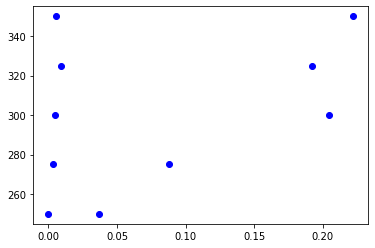

In [9]:
pdD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/D4')
pds = pdD4.phase_diagram()
plt.plot(pds[0].mean(axis=1), pdD4.temperatures, 'bo')
plt.plot(pds[1].mean(axis=1), pdD4.temperatures, 'bo')

> Run Completed at 100.00% for CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


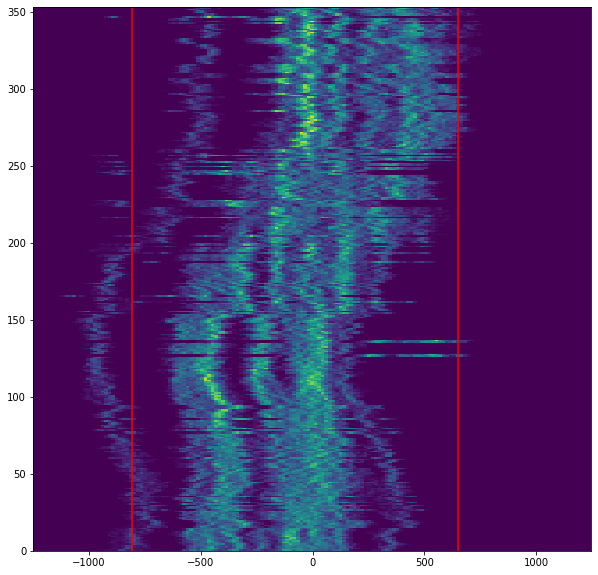

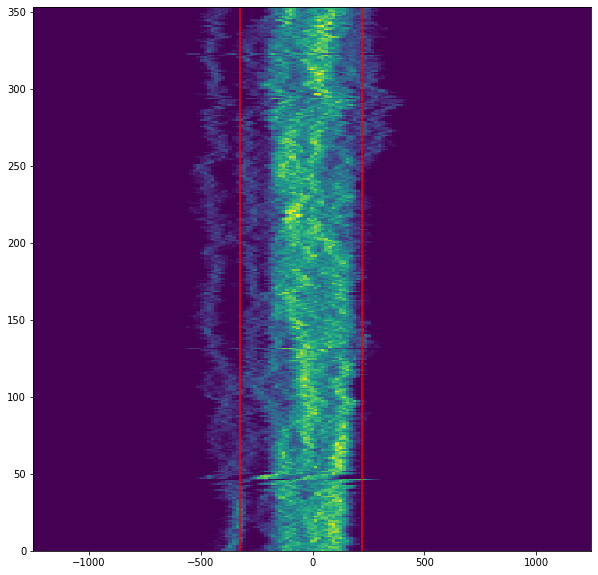

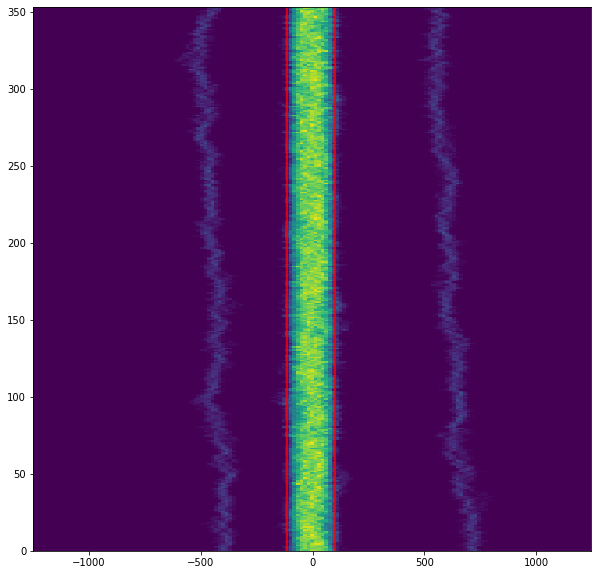

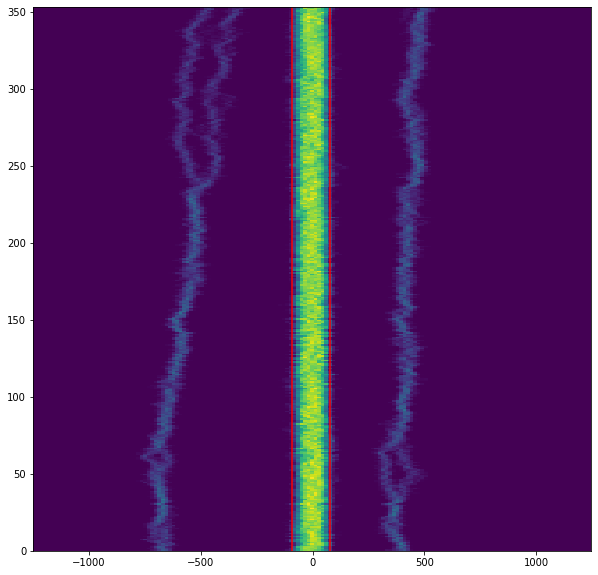

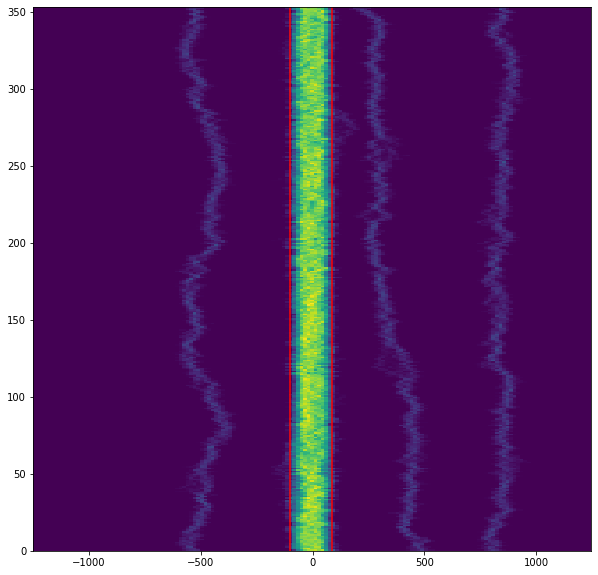

In [6]:
pdD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/D4')
for T in range(len(pdD4.temperatures)):
    z, rho_z = pdD4.density_profile(T=T, noise=False)
    interface = pdD4.interface_position(rho_z=rho_z.mean(axis=0), z=z)
    plt.figure(figsize=(10,10))
    plt.imshow(rho_z, extent=[z.min(), z.max(), 0,rho_z.shape[0]], aspect='auto')
    plt.axvline(interface[0], color='red')
    plt.axvline(interface[1], color='red')

#### Comparing both phase diagrams, we obtain the following

> Run Completed at 100.00% for CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
> Interface fit failed for negative z, returning 0 (no interface) !!!
> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


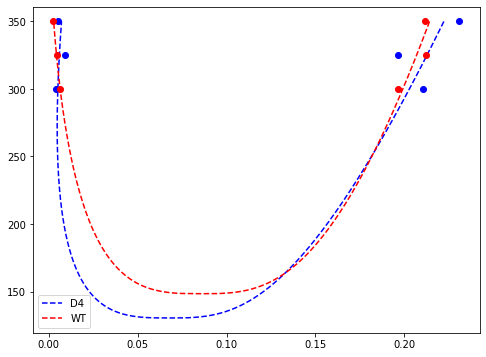

In [53]:
plt.figure(figsize=(8,6))

pdD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/D4')
pds = pdD4.phase_diagram()
rho_c = pds[1].mean(axis=1)
rho_d = pds[0].mean(axis=1)
fit, critical_point = pdD4.find_Tc_from_diagram(rho_c=rho_c[2:], rho_d=rho_d[2:], temperatures=pdD4.temperatures[2:])

plt.plot(pds[0].mean(axis=1)[2:], pdD4.temperatures[2:], 'bo')
plt.plot(pds[1].mean(axis=1)[2:], pdD4.temperatures[2:], 'bo')
plt.plot(fit[0],fit[1], '--b', label='D4')


pdWT = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/WT')
pds = pdWT.phase_diagram()
rho_c = pds[1].mean(axis=1)
rho_d = pds[0].mean(axis=1)
fit, critical_point = pdWT.find_Tc_from_diagram(rho_c=rho_c[2:], rho_d=rho_d[2:], temperatures=pdWT.temperatures[2:])

plt.plot(pds[0].mean(axis=1)[2:], pdD4.temperatures[2:], 'ro')
plt.plot(pds[1].mean(axis=1)[2:], pdD4.temperatures[2:], 'ro')
plt.plot(fit[0],fit[1], '--r', label='WT')

plt.legend()

### 3. Phospho Phase diagrams <a id='3'></a>

In [21]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/12D',
                  host='@perdiu42',
                  protein='12D_CPEB4_D4',
                  chains=20, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=4,
                  hps_scale=0.8,
                  use_random=True,
                  slab=True,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔══════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/12D for 12D_CPEB4_D4     ║
║------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                         ║
║       - Model = HPS-T                                                                                ║
║       - Chains = 20                                                                                  ║
║       - Ionic Strength (mM) = 0.1                                                                    ║
║       - Medium Permittivity = 80.0                                                                   ║
║       - Temperatures (K) = [250. 275. 300. 325. 350.]                                                ║
║       - HPS Scale = 0.8                              

(5, 2, 7)
> Run Completed at 100.00% for 12D_CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


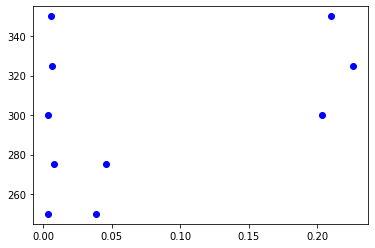

In [15]:
pdD12 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/12D')
pds = pdD12.phase_diagram()
plt.plot(pds[0].mean(axis=1), pdD12.temperatures, 'bo')
plt.plot(pds[1].mean(axis=1), pdD12.temperatures, 'bo')

> Run Completed at 100.00% for 12D_CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


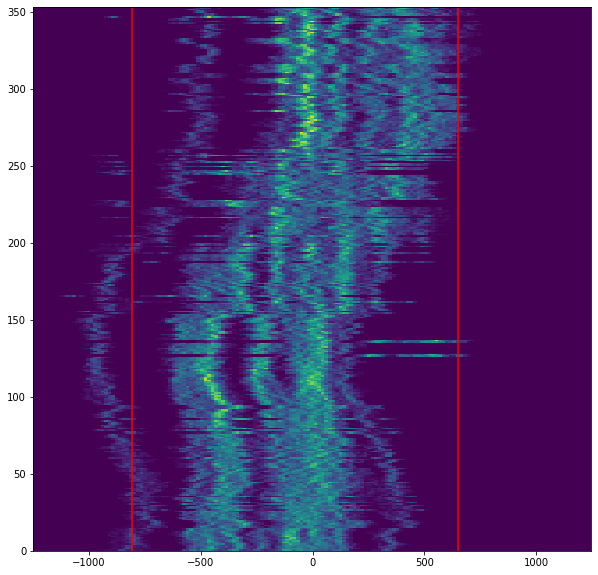

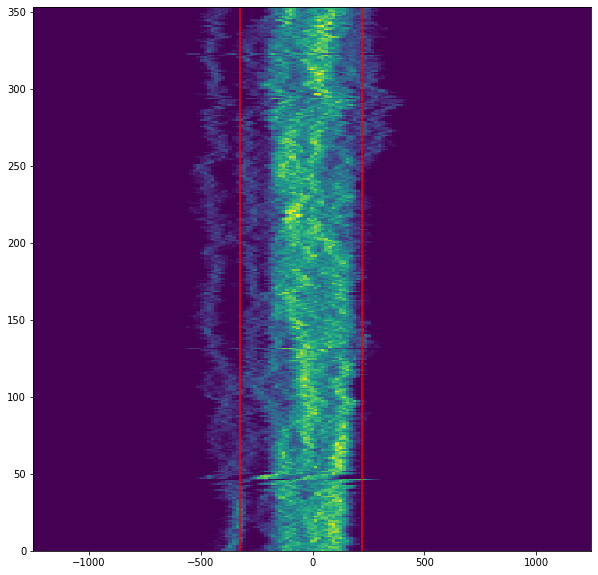

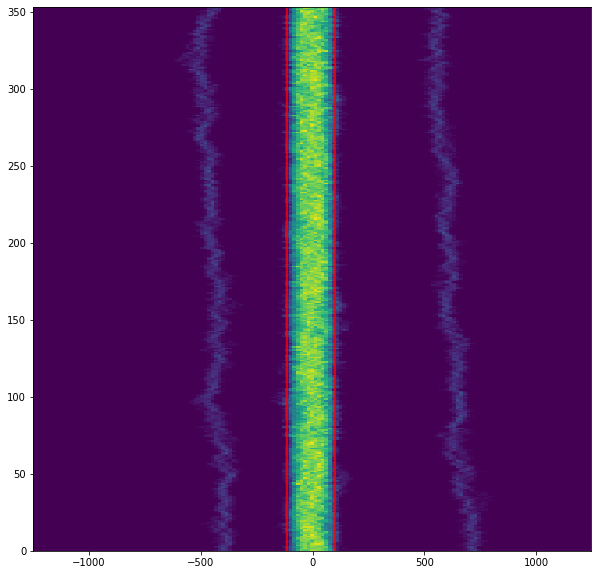

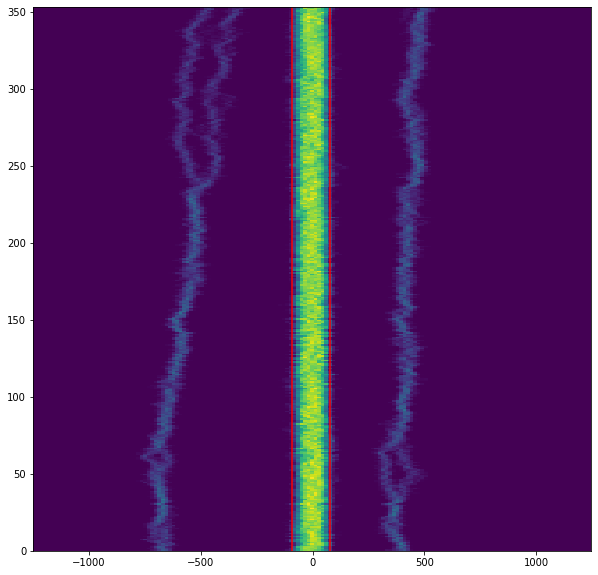

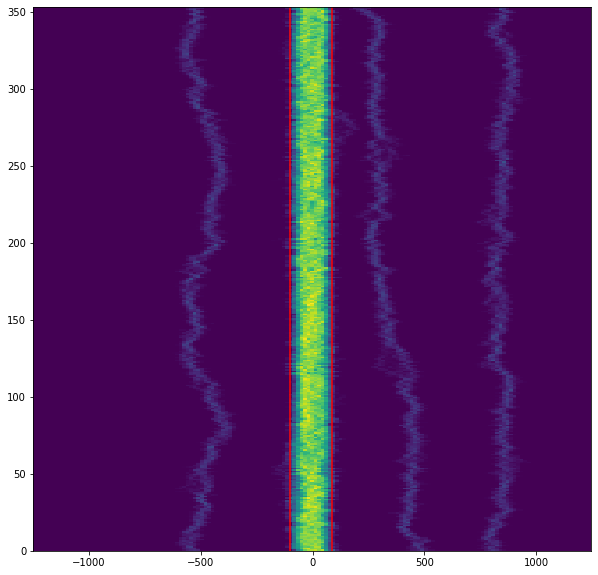

In [16]:
pdD12 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/12D')
for T in range(len(pdD12.temperatures)):
    z, rho_z = pdD4.density_profile(T=T, noise=False)
    interface = pdD4.interface_position(rho_z=rho_z.mean(axis=0), z=z)
    plt.figure(figsize=(10,10))
    plt.imshow(rho_z, extent=[z.min(), z.max(), 0,rho_z.shape[0]], aspect='auto')
    plt.axvline(interface[0], color='red')
    plt.axvline(interface[1], color='red')

#### Comparing both phase diagrams, we obtain the following

> Run Completed at 100.00% for CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
> Interface fit failed for negative z, returning 0 (no interface) !!!
> Run Completed at 100.00% for 12D_CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


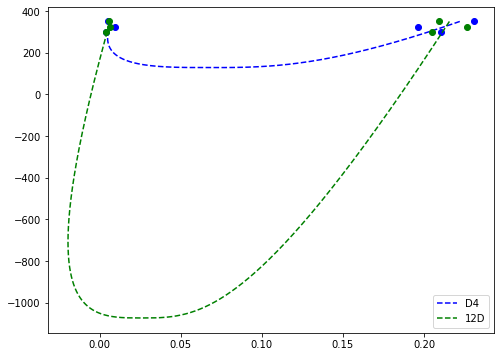

In [55]:
plt.figure(figsize=(8,6))

pdD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/D4')
pds = pdD4.phase_diagram()
rho_c = pds[1].mean(axis=1)
rho_d = pds[0].mean(axis=1)
fit, critical_point = pdD4.find_Tc_from_diagram(rho_c=rho_c[2:], rho_d=rho_d[2:], temperatures=pdD4.temperatures[2:])

plt.plot(pds[0].mean(axis=1)[2:], pdD4.temperatures[2:], 'bo')
plt.plot(pds[1].mean(axis=1)[2:], pdD4.temperatures[2:], 'bo')
plt.plot(fit[0],fit[1], '--b', label='D4')


pd12D = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/12D')
pds = pd12D.phase_diagram()
rho_c = pds[1].mean(axis=1)
rho_d = pds[0].mean(axis=1)
fit, critical_point = pd12D.find_Tc_from_diagram(rho_c=rho_c[2:], rho_d=rho_d[2:], temperatures=pdWT.temperatures[2:])

plt.plot(pds[0].mean(axis=1)[2:], pdD4.temperatures[2:], 'go')
plt.plot(pds[1].mean(axis=1)[2:], pdD4.temperatures[2:], 'go')
plt.plot(fit[0],fit[1], '--g', label='12D')

plt.legend()

### 4. Single chain to criticality <a id='4'></a>

In [15]:
temperatures = np.linspace(250,350,5)

In [16]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/WT',
                  host='@perdiu38',
                  protein='CPEB4',
                  chains=1, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=3,
                  hps_scale=0.8,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔══════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/WT for CPEB4     ║
║----------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                             ║
║       - Model = HPS-T                                                                                    ║
║       - Chains = 1                                                                                       ║
║       - Ionic Strength (mM) = 0.1                                                                        ║
║       - Medium Permittivity = 80.0                                                                       ║
║       - Temperatures (K) = [250. 275. 300. 325. 350.]                                                    ║
║       - HPS Scale

In [17]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/D4',
                  host='@perdiu39',
                  protein='CPEB4_D4',
                  chains=1, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=3,
                  hps_scale=0.8,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔═════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/D4 for CPEB4_D4     ║
║-------------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                                ║
║       - Model = HPS-T                                                                                       ║
║       - Chains = 1                                                                                          ║
║       - Ionic Strength (mM) = 0.1                                                                           ║
║       - Medium Permittivity = 80.0                                                                          ║
║       - Temperatures (K) = [250. 275. 300. 325. 350.]                                                 

In [18]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/12D',
                  host='@perdiu40',
                  protein='12D_CPEB4_D4',
                  chains=1, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=3,
                  hps_scale=0.8,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/12D for 12D_CPEB4_D4     ║
║------------------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                                     ║
║       - Model = HPS-T                                                                                            ║
║       - Chains = 1                                                                                               ║
║       - Ionic Strength (mM) = 0.1                                                                                ║
║       - Medium Permittivity = 80.0                                                                               ║
║       - Temperatures (K) = [250. 275. 300. 325. 350.]         

**Radius of gyration change between having or not E4**

In [19]:
rgWT = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/WT').rg()
rgD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/D4').rg()
rgWT_err = analysis.Analysis(oliba_wd=None).block_error(rgWT)
rgD4_err = analysis.Analysis(oliba_wd=None).block_error(rgD4)

> Run Completed at 69.30% for CPEB4. Ran 693000000 steps for a total of 13861 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
> Run Completed at 68.17% for CPEB4_D4. Ran 681700000 steps for a total of 13635 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


> Run Completed at 70.60% for CPEB4. Ran 706050000 steps for a total of 14122 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
47.52543178832432 47.09918612177214


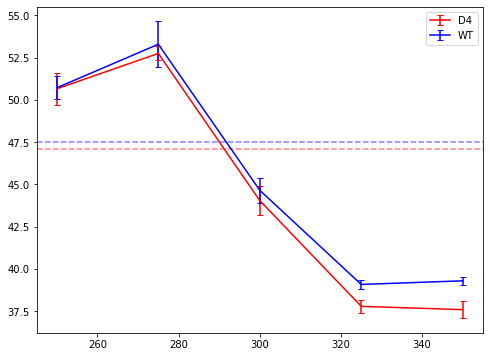

In [37]:
ss =  analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/WT')
temperatures = ss.temperatures

theta_rg_WT = 5.5*448**0.5/np.sqrt(6)
theta_rg_D4 = 5.5*440**0.5/np.sqrt(6)

print(theta_rg_WT, theta_rg_D4)

plt.figure(figsize=(8,6))
plt.axhline(theta_rg_WT, ls='--', color='b', alpha=0.5)
plt.axhline(theta_rg_D4, ls='--', color='r', alpha=0.5)

plt.errorbar(temperatures, rgD4.mean(axis=1), yerr=rgD4_err, markersize=3, color='red', linestyle='-', label='D4', capsize=3)
plt.errorbar(temperatures, rgWT.mean(axis=1), yerr=rgWT_err, markersize=1,  color='blue', linestyle='-',  label='WT', capsize=3)
# plt.plot(temperatures, rgWT.mean(axis=1), '--bo', label='WT')
# plt.plot(temperatures, rgD4.mean(axis=1), '--ro', label='D4')
plt.legend()

**Radius of gyration change between having or not phosphorilations**

In [6]:
rgD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/D4').rg()
rg12D = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/12D').rg()
temperatures =  analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/D4').temperatures
rg_err = analysis.Analysis(oliba_wd=None)
rgD4_err = analysis.Analysis(oliba_wd=None).block_error(rgD4)
rg12D_err = analysis.Analysis(oliba_wd=None).block_error(rg12D)

> Run Completed at 68.09% for CPEB4_D4. Ran 680950000 steps for a total of 13620 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
> Run Completed at 66.12% for 12D_CPEB4_D4. Ran 661250000 steps for a total of 13226 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
> Run Completed at 68.11% for CPEB4_D4. Ran 681100000 steps for a total of 13623 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


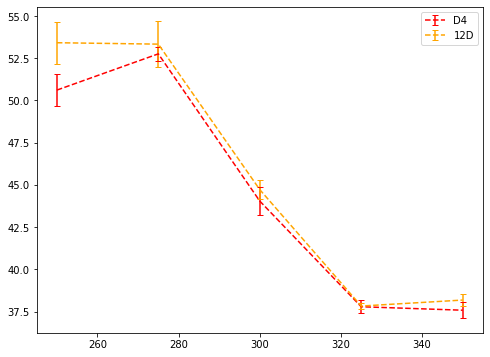

In [18]:
plt.figure(figsize=(8,6))
plt.errorbar(temperatures, rgD4.mean(axis=1), yerr=rgD4_err, markersize=3, color='red', linestyle='--', label='D4', capsize=3)
plt.errorbar(temperatures, rg12D.mean(axis=1), yerr=rg12D_err, markersize=1,  color='orange', linestyle='--',  label='12D', capsize=3)
plt.legend()

### 4. Maximization of Rg Difference <a id='4.1'></a>

Let's try a maximization on the difference of Rgs

In [5]:
temperatures = np.linspace(250,350,5)

In [6]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/D4-BIG',
                  host='@perdiu34',
                  protein='CPEB4_D4',
                  chains=1, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=3,
                  hps_scale=0.8,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/D4-BIG for CPEB4_D4     ║
║-----------------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                                    ║
║       - Model = HPS-T                                                                                           ║
║       - Chains = 1                                                                                              ║
║       - Ionic Strength (mM) = 0.1                                                                               ║
║       - Medium Permittivity = 80.0                                                                              ║
║       - Temperatures (K) = [250. 275. 300. 325. 350.]                 

In [7]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/12D-BIG',
                  host='@perdiu35',
                  protein='12D_CPEB4_D4',
                  chains=1, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=3,
                  hps_scale=0.8,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files()

╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/12D-BIG for 12D_CPEB4_D4     ║
║----------------------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                                         ║
║       - Model = HPS-T                                                                                                ║
║       - Chains = 1                                                                                                   ║
║       - Ionic Strength (mM) = 0.1                                                                                    ║
║       - Medium Permittivity = 80.0                                                                                   ║
║       - Temperatures (K) = [25

In [36]:
maximizer = analysis.Analysis(oliba_wd=None)
maximizer.maximize_charge(a_dir='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/D4-BIG',
                         b_dir='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.8/SingleChain/12D-BIG',
                         T=1,
                         l0=0.8,
                         eps0=80)

> Run Completed at 3.65% for CPEB4_D4. Ran 36450000 steps for a total of 730 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
> Run Completed at 3.53% for 12D_CPEB4_D4. Ran 35300000 steps for a total of 707 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
I=0.1, ls=0.8053169554419393, eps=80.55319460183377
Rw RgA, 43.033, Rw RgB 41.918, diff 1.12, dist to mean -8.23, cost 66.55
Neff-A, 0.0658470662000026 Neff-B, 0.0645626575400614


KeyboardInterrupt: 

### 5. Contact Test <a id='5'></a>

In [33]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/CONTACT-TEST4',
                  host='@perdiu41',
                  temper=False,
                  protein='LAF-1_RGG',
                  chains=50, 
                  model='HPS-T',
                  save=20000,
                  t=int(1e9),
                  use_random=True,
                  slab=True,
                  processors=6,
                  hps_scale=1.0,
                  temperatures=[250],
                  debye=0.1).write_hps_files(qsub=True)

╔═══════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/CONTACT-TEST3 for LAF-1_RGG     ║
║---------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                      ║
║       - Model = HPS-T                                                                             ║
║       - Chains = 50                                                                               ║
║       - Ionic Strength (mM) = 0.1                                                                 ║
║       - Medium Permittivity = 80.0                                                                ║
║       - Temperatures (K) = [250]                                                                  ║
║       - HPS Scale = 1.0                                                         

In [2]:
t = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/CONTACT-TEST4')

> Run Completed at 100.00% for LAF-1_RGG. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


In [3]:
intra, inter = t.multi_chain_contact_map()

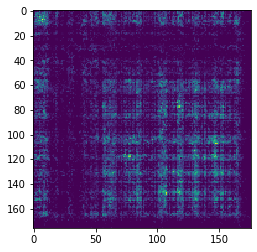

In [5]:
fig,ax = 
plt.imshow(inter[0])

### 6. gHPS-T Test<a id='6'></a>

Let's run a similar test to single chain WT at 0.8 to see if Giulio's idea works on a LAMMPS GPU. However we can only produce 3 temperatures since we have 3 available GPUs

In [162]:
temperatures = np.linspace(250,350,5)
temperatures = temperatures[:4]

lmpsetup.LMPSetup(oliba_wd='/home/adria/irb/lammps/0.8/WT',
                  protein='CPEB4',
                  chains=1, 
                  model='gHPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=1,
                  hps_scale=0.8,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files(qsub=False)

[autoreload of lmpsetup failed: Traceback (most recent call last):
  File "/home/adria/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/adria/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/adria/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/adria/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/adria/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/home/adria/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visite

True -0.40137280000000053
False 0.1126815999999996
False 0.28005183999999983
False 0.2337625599999995
False 0.1372239999999998
False 0.2597084799999999
False 0.30599807999999995
False 0.15452127999999976
True -0.4736419199999995
True -0.32353504000000055
True -0.32353504000000055
False 0.2770060799999998
True -0.36677824000000014
True -0.31796639999999976
False 0.2669535999999999
False 0.3319439999999997
False 0.3578899199999994
True -0.33526367999999995
True -0.36120959999999913
True -0.34948096000000084
False 0.6267359999999996
False 0.7941062399999999
False 0.7478169599999995
False 0.6512783999999998
False 0.7737628799999999
False 0.82005248
False 0.6685756799999998
False 0.04041248000000053
False 0.19051935999999947
False 0.19051935999999947
False 0.7910604799999998
False 0.1472761600000001
False 0.19608800000000026
False 0.7810079999999999
False 0.8459983999999998
False 0.8719443199999996
False 0.17879072000000007
False 0.15284480000000078
False 0.16457343999999907
False 0.9614764

False 0.7200831999999968
False 0.4487583999999979
False 0.5861190399999987
False 0.5698393599999978
False 0.6479631999999984
False 0.5957852799999981
False 0.6120652799999988
False 0.6652604799999983
False 0.65156608
False 0.7979209599999968
False 0.7979209599999968
False 0.6130828799999981
False 0.7546777599999974
False 0.8072415999999999
False 0.7776927999999984
False 0.6380111999999984
False 0.6639571199999983
False 0.7899443199999997
False 0.7639984000000004
False 0.7719750399999964
False 0.17743359999999875
False 0.31479423999999956
False 0.29851455999999865
False 0.37663839999999926
False 0.32446047999999905
False 0.3407404799999997
False 0.39393567999999923
False 0.380241280000001
False 0.5265961599999978
False 0.5265961599999978
False 0.3417580799999991
False 0.4833529599999983
False 0.5359168000000007
False 0.5063679999999993
False 0.3666863999999994
False 0.39263231999999926
False 0.5186195200000006
False 0.4926736000000014
False 0.5006502399999974
False 0.4521548800000005
Fa

╔════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/irb/lammps/0.8/WT for CPEB4     ║
║------------------------------------------------------------------------║
║   PARAMETERS                                                           ║
║       - Model = gHPS-T                                                 ║
║       - Chains = 1                                                     ║
║       - Ionic Strength (mM) = 0.1                                      ║
║       - Medium Permittivity = 80.0                                     ║
║       - Temperatures (K) = [250. 275. 300. 325.]                       ║
║       - HPS Scale = 0.8                                                ║
╚════════════════════════════════════════════════════════════════════════╝


Use of gHPS-T is in general not viable since we can't correlate with negative lambdas. Maybe a future work can be done to solve this

### 7. Further Phase diagrams <a id='7'></a>

In [15]:
temperatures = np.linspace(270,320,12)

In [20]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/WT',
                  host='@perdiu46',
                  protein='CPEB4',
                  chains=20, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=2,
                  hps_scale=0.75,
                  slab=True,
                  use_random=True,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files(qsub=False, slurm=True)

╔═══════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/WT for CPEB4     ║
║-----------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                  ║
║       - Model = HPS-T                                                                         ║
║       - Chains = 20                                                                           ║
║       - Ionic Strength (mM) = 0.1                                                             ║
║       - Medium Permittivity = 80.0                                                            ║
║       - Temperatures (K) = [270.         274.54545455 279.09090909 283.63636364 288.18181818
 292.72727273 297.27272727 301.81818182 306.36363636 310.90909091
 315.45454545 320.        ]    ║
║       - HPS Scale = 

> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


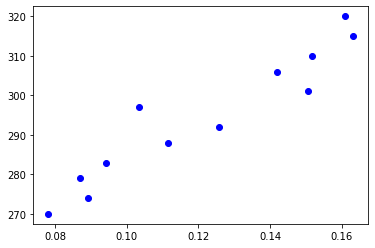

In [20]:
pdD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/WT', equil_frames=5)
pds = pdD4.phase_diagram()
# plt.plot(pds[0].mean(axis=1), pdD4.temperatures, 'bo')
plt.plot(pds[1].mean(axis=1), pdD4.temperatures, 'bo')

In [12]:
intraWT, interWT = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/WT', equil_frames=5).multi_chain_contact_map(temperature=11)

> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
<mdtraj.Trajectory with 208 frames, 8960 atoms, 8960 residues, and unitcells>


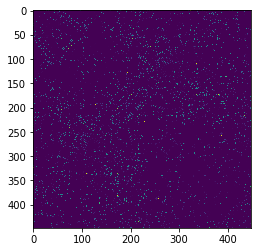

In [15]:
plt.imshow(interWT[0])

In [55]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/SingleChain/D4',
                  host='@perdiu47',
                  protein='CPEB4_D4',
                  chains=1, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=2,
                  hps_scale=0.75,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files(qsub=False, slurm=True)

╔══════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/SingleChain/D4 for CPEB4_D4     ║
║--------------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                                 ║
║       - Model = HPS-T                                                                                        ║
║       - Chains = 1                                                                                           ║
║       - Ionic Strength (mM) = 0.1                                                                            ║
║       - Medium Permittivity = 80.0                                                                           ║
║       - Temperatures (K) = [270.         274.54545455 279.09090909 283.63636364 288.18181818
 

> Run Completed at 100.00% for CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
INTERFACE [-300.8144814481448, 261.1877187718772]
INTERFACE [-263.5553555355536, 354.02400240024]
INTERFACE [-313.27572757275726, 215.5795579557956]
INTERFACE [-224.92549254925493, 213.2119211921192]
INTERFACE [-208.35203520352036, 190.65706570657065]
INTERFACE [-203.6167616761676, 173.33593359335933]
INTERFACE [-181.18651865186519, 175.0805080508051]
INTERFACE [-181.18651865186519, 159.37933793379338]
INTERFACE [-151.52875287528752, 143.42894289428943]
INTERFACE [-151.15491549154916, 147.54115411541153]
INTERFACE [-153.2733273327333, 138.81828182818282]
INTERFACE [-140.81208120812082, 126.23242324232423]


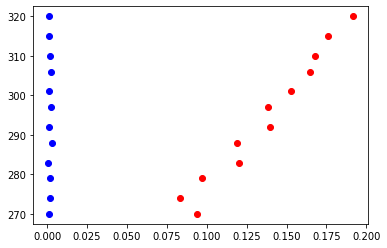

In [22]:
pdD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/D4', equil_frames=5)
pds = pdD4.phase_diagram()
plt.plot(pds[0].mean(axis=1), pdD4.temperatures, 'bo')
plt.plot(pds[1].mean(axis=1), pdD4.temperatures, 'ro')

In [ ]:
pdD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/D4', equil_frames=5)
pds = pdD4.phase_diagram()
plt.plot(pds[0].mean(axis=1), pdD4.temperatures, 'bo')
plt.plot(pds[1].mean(axis=1), pdD4.temperatures, 'bo')

In [16]:
intraD4, interD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/D4', equil_frames=5).multi_chain_contact_map(temperature=11)

> Run Completed at 100.00% for CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


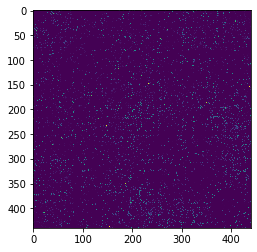

In [18]:
plt.imshow(interD4[0])

> Run Completed at 100.00% for CPEB4_D4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
(12, 118)
(12,)
> Run Completed at 100.00% for CPEB4. Ran 20000 steps for a total of 2 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


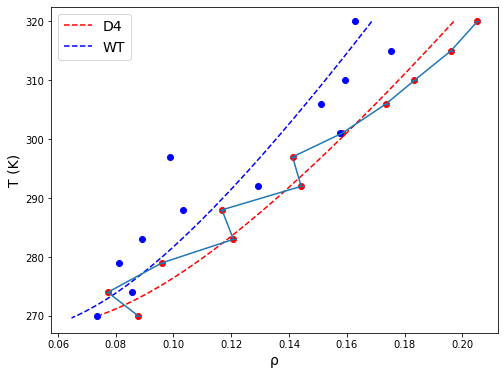

In [51]:
plt.figure(figsize=(8,6))
plt.xlabel("ρ", fontsize=14)
plt.ylabel("T (K)", fontsize=14)

pdD4 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/D4', equil_frames=100)
pds = pdD4.phase_diagram()
rho_c = pds[1].mean(axis=1)
rho_d = pds[0].mean(axis=1)
e_rho_c = analysis.Analysis(oliba_wd=None).block_error(pds[1])
e_rho_d = analysis.Analysis(oliba_wd=None).block_error(pds[1])

print(pds[1].shape)
print(e_rho_c.shape)


fit, critical_point = pdD4.find_Tc_from_diagram(rho_c=rho_c, rho_d=rho_d, temperatures=pdD4.temperatures)

# plt.plot(pds[0].mean(axis=1), pdD4.temperatures, 'ro')
plt.plot(pds[1].mean(axis=1), pdD4.temperatures, 'ro')
# plt.errorbar(pds[1].mean(axis=1), pdD4.temperatures, yerr=e_rho_c, capsize=3)
plt.plot(fit[0,:-100],fit[1,:-100], '--r', label='D4')


pdWT = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/WT', equil_frames=100)
pds = pdWT.phase_diagram()
rho_c = pds[1].mean(axis=1)
rho_d = pds[0].mean(axis=1)
fit, critical_point = pdWT.find_Tc_from_diagram(rho_c=rho_c, rho_d=rho_d, temperatures=pdWT.temperatures)

# plt.plot(pds[0].mean(axis=1), pdD4.temperatures, 'bo')
plt.plot(pds[1].mean(axis=1), pdD4.temperatures, 'bo')
plt.plot(fit[0,:-100],fit[1, :-100], '--b', label='WT')

plt.legend(fontsize=14)

In [152]:
lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/SingleChain/12D',
                  host='@perdiu42',
                  protein='12D_CPEB4_D4',
                  chains=20, 
                  model='HPS-T',
                  save=50000,
                  t=int(1e9),
                  processors=3,
                  hps_scale=0.75,
                  use_random=True,
                  slab=True,
                  temperatures=temperatures,
                  debye=0.1).write_hps_files(qsub=False, slurm=True)

╔═══════════════════════════════════════════════════════════════════════════════════════════════════════╗
║     Input files created at /home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/12D for 12D_CPEB4_D4     ║
║-------------------------------------------------------------------------------------------------------║
║   PARAMETERS                                                                                          ║
║       - Model = HPS-T                                                                                 ║
║       - Chains = 20                                                                                   ║
║       - Ionic Strength (mM) = 0.1                                                                     ║
║       - Medium Permittivity = 80.0                                                                    ║
║       - Temperatures (K) = [270.         274.54545455 279.09090909 283.63636364 288.18181818
 292.72727273 297.27272727 301.81818182 306.36363636 310.

Single chain thingy

In [52]:
s1 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/SingleChain/WT')
s2 = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/0.75/SingleChain/D4')
WT = s1.rg()
D4 = s2.rg()

> Run Completed at 35.91% for CPEB4. Ran 359150000 steps for a total of 7184 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations
> Run Completed at 34.83% for CPEB4_D4. Ran 348300000 steps for a total of 6967 frames 
> Taking frames every 1 for a total of 10000 to avoid strong correlations


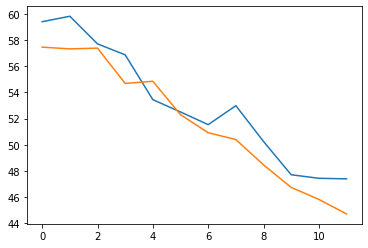

In [53]:
plt.plot(WT.mean(axis=1))
plt.plot(D4.mean(axis=1))